In [1]:
import torch
import numpy as np
import pandas as pd
#import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# # Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(
#     f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# # Set the device
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# print(f"Using device: {device}")


PyTorch version: 1.9.0


In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

# Creating the tensor product for the transformer using einsum notation

In [3]:
#for single head attention
a = torch.randint(0,10,(2,3,2,2,2))
print(a.shape)

qk = torch.einsum("bhtfe,bhtfe->bhtf", a, a)
print(qk.shape)
qkv = torch.einsum("bhtf,bhtfe->bhtfe", qk, a)
print(qkv.shape)



torch.Size([2, 3, 2, 2, 2])
torch.Size([2, 3, 2, 2])
torch.Size([2, 3, 2, 2, 2])


In [4]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

a = ["hello how are you, hello I'm good. Wassup?" , "hey there, how are you doing?"]

#add padding so all sequences are the same length
max_len = max([len(tokenizer(i)) for i in a])
a = [i + " <pad>"*(max_len - len(tokenizer(i))) for i in a]

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

for value in yield_tokens(a):
    print(value)


vocab = build_vocab_from_iterator(yield_tokens(a), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

print(vocab.get_itos())

PAD_TOKEN = vocab(tokenizer('<pad>'))
PAD_TOKEN = PAD_TOKEN[0]

print(PAD_TOKEN)

embedding = nn.Embedding(len(vocab), 3, padding_idx=PAD_TOKEN)
print(embedding)

tokenized_a = [vocab(tokenizer(i)) for i in a]
print(tokenized_a)

tokenized_a = torch.tensor(tokenized_a)
embedded_a = embedding(tokenized_a)
print(embedded_a.shape)





['hello', 'how', 'are', 'you', ',', 'hello', 'i', "'", 'm', 'good', '.', 'wassup', '?']
['hey', 'there', ',', 'how', 'are', 'you', 'doing', '?', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<unk>', '<pad>', ',', '?', 'are', 'hello', 'how', 'you', "'", '.', 'doing', 'good', 'hey', 'i', 'm', 'there', 'wassup']
1
Embedding(17, 3, padding_idx=1)
[[5, 6, 4, 7, 2, 5, 13, 8, 14, 11, 9, 16, 3], [12, 15, 2, 6, 4, 7, 10, 3, 1, 1, 1, 1, 1]]
torch.Size([2, 13, 3])


In [5]:
embedding = nn.Embedding(4, 3)
embedding(torch.tensor([1]))


tensor([[ 1.1771, -0.5723,  0.9439]], grad_fn=<EmbeddingBackward>)

In [6]:
#create some random time series data, we have n subjects, across m time points, with p features
n = 5
m = 10
p = 7

data = torch.randint(0, 10, (n,m,p))
print(data[1:3,1:3,1:3])
#lets embed the data
embedding = nn.Embedding(10, 3, padding_idx=0)
embedded_data = embedding(data)
print(embedded_data[1:3,1:3,1:3])

tensor([[[4, 5],
         [1, 6]],

        [[2, 1],
         [9, 5]]])
tensor([[[[ 0.8213, -0.1575,  0.0642],
          [ 0.8422, -1.6730,  2.1020]],

         [[-1.5936, -1.2188, -0.6495],
          [ 0.9333, -0.6643, -0.3641]]],


        [[[ 2.6959,  0.4189, -0.9332],
          [-1.5936, -1.2188, -0.6495]],

         [[-1.0722, -0.1521,  1.5490],
          [ 0.8422, -1.6730,  2.1020]]]], grad_fn=<SliceBackward>)


# Create a Transformer

In [7]:
#create a transformer based on the tensor product above

class times_series_attention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(times_series_attention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads


        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(embed_dim, embed_dim)
        self.output_linear = nn.Linear(embed_dim, embed_dim)


    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor = None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension, 
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]


        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        key_reshaped = key_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(b, t, f, self.num_heads, self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE
        value_reshaped = value_reshaped.permute(0, 3, 1, 2, 4) # BxHxTxFxE


        kq = torch.einsum("bhtfe,bhxye->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq/math.sqrt(self.dim_per_head)

        # if mask is not None:
        #     # We simply set the similarity scores to be near zero for the positions
        #     # where the attention should not be done. Think of why we do this.
        #     dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        #softmac across time and features
        dot_prod_scores = F.softmax(dot_prod_scores, dim=4)
        dot_prod_scores = F.softmax(dot_prod_scores, dim=5)

        out = torch.einsum("bhtfxy,bhtfe->btfhe",
                           dot_prod_scores, value_reshaped)
        out = self.output_linear(out.reshape(b, t, f, e))

        return out


In [8]:
#lets test it out
x = torch.randint(0, 10, (2,3,4,6)).float()
# mask = torch.randn((2,3,4,1)) > 0.5
num_heads = 2
embed_dim = 6
model = times_series_attention(embed_dim, num_heads)
out = model(x, x, x)
print(out.shape)


torch.Size([2, 3, 4, 6])


In [9]:
# feed forward network
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, embed_dim, ff_dim, dropout):
        """
        Inputs:
        - embed_dim: embedding dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
          
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        y = self.feedforward(x)

        
        return y
        

In [10]:
#transformer cell

class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = times_series_attention(embed_dim, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.feedforward = FeedForwardNetwork(embed_dim, ff_dim, dropout)


    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention = self.time_series_attention(x, x, x, mask)
        attention = self.dropout(attention)
        attention = torch.add(attention, x)
        attention = self.layer_norm(attention)

        y = self.feedforward(attention)
        y = torch.add(y, attention)
        y = self.layer_norm(y)

        return y


In [11]:
# implement transformer encoder 

class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None

        self.encoder_modules = nn.ModuleList(TransformerEncoderCell(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_cells))
        self.layer_norm = nn.LayerNorm(embed_dim)

        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape BxTxFXE
        """

        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)
          
        #y = self.layer_norm(x)
        y = x

        return y

In [12]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim=128, projection_dim=None):
        super().__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, projection_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1)
                               * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat(
            [torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table


torch.Size([128])


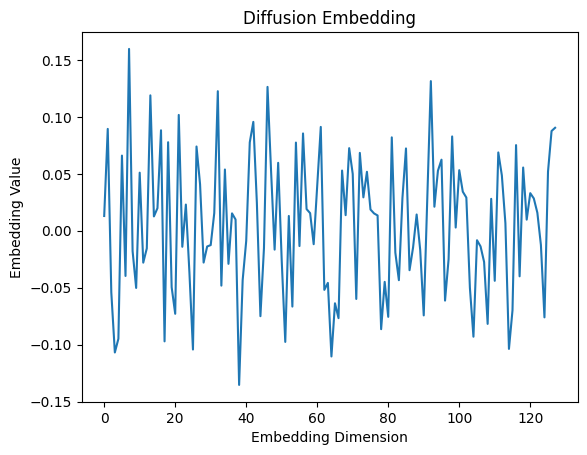

In [13]:
# let's visualize the embedding 
num_steps = 100
embedding_dim = 128
projection_dim = 128
diffusion_embedding = DiffusionEmbedding(num_steps, embedding_dim, projection_dim)
x = diffusion_embedding(10)
print(x.shape)
#plot
plt.plot(x.detach().numpy())
plt.title('Diffusion Embedding')
plt.xlabel('Embedding Dimension')
plt.ylabel('Embedding Value')
plt.show()

# Diffusion

## Noise (beta) schedule

In [14]:
import enum
import math

import torch
import numpy as np
import torch.nn as nn

#from .nn import mean_flat
#from .losses import normal_kl, discretized_gaussian_log_likelihood

In [15]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)



In [16]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, shape, embedding_dim=128, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.shape = shape
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, shape[-1])

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(self.shape) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table
    

class TimeEmbedding(nn.Module):
    def __init__(self, shape, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.shape = shape
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(shape[-1], shape[-1]),
            nn.SiLU(),
            nn.Linear(shape[-1], shape[-1])
        )
        

    def forward(self):
        b, l, f, e = self.shape
        pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        pe = torch.zeros(self.shape) + pe
        
        div_term = 1 / torch.pow(
            self.max_len, torch.arange(0, f, 2) / f
        ).unsqueeze(-1)

        pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe) 
    
class FeatureEmbedding(nn.Module):
    def __init__(self, shape, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.shape = shape
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(shape[-1], shape[-1]),
            nn.SiLU(),
            nn.Linear(shape[-1], shape[-1])
        )
        

    def forward(self):
        b, l, f, e = self.shape
        pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
        pe = torch.zeros(self.shape) + pe

        div_term = 1 / torch.pow(
            self.max_len, torch.arange(0, e, 2) / e
        )

        pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

In [17]:
a = torch.randn((2, 3, 4, 6))
diffusion_embedding = DiffusionEmbedding(100, a.shape)
print(diffusion_embedding([1, 3]).shape)

time_embedding = TimeEmbedding(a.shape)
print(time_embedding().shape)

embedding = torch.stack([diffusion_embedding([1, 3]), time_embedding()], dim=-1)
embedding = embedding.reshape(1, -1, 2)
embedding = embedding.permute(0, 2, 1)
print(embedding.shape)
convolution_embed = nn.Conv1d(2, 1, 1)
embedding = convolution_embed(embedding)
embedding = embedding.permute(0, 2, 1)
embedding = embedding.reshape(2, 3, 4, 6)
print(convolution_embed.weight)
print(embedding)

torch.Size([2, 3, 4, 6])
torch.Size([2, 3, 4, 6])
torch.Size([1, 2, 144])
Parameter containing:
tensor([[[-0.1025],
         [-0.6730]]], requires_grad=True)
tensor([[[[-0.0946, -0.0912, -0.3029, -0.2905, -0.3540, -0.0294],
          [-0.0915, -0.0554, -0.2744, -0.1892, -0.3734, -0.0273],
          [-0.0946, -0.0912, -0.3029, -0.2905, -0.3540, -0.0294],
          [-0.0915, -0.0554, -0.2744, -0.1892, -0.3734, -0.0273]],

         [[-0.0928, -0.0598, -0.2803, -0.2010, -0.3744, -0.0337],
          [-0.0944, -0.0695, -0.2901, -0.2275, -0.3723, -0.0400],
          [-0.0946, -0.0907, -0.3027, -0.2892, -0.3545, -0.0299],
          [-0.0915, -0.0554, -0.2744, -0.1892, -0.3734, -0.0273]],

         [[-0.0923, -0.0579, -0.2778, -0.1958, -0.3741, -0.0312],
          [-0.0923, -0.1119, -0.3085, -0.3523, -0.3274, -0.0021],
          [-0.0947, -0.0902, -0.3025, -0.2878, -0.3550, -0.0303],
          [-0.0915, -0.0554, -0.2744, -0.1892, -0.3734, -0.0274]]],


        [[[-0.0708, -0.0929, -0.3064, -0.3

In [140]:
class diffusion_imputation(nn.Module):
    def __init__(self, emb_dim,
                vocab_size,
                pad_idx= None,
                features_to_impute = None,
                missing_prp = 0.2,
                diffusion_steps = 1000,
                diffusion_beta_schedule = "cosine",
                is_unconditional=False,
                conv_out_channels = 4,
                num_heads = 8,
                ff_dim = 512,
                num_cells = 2,
                dropout = 0.1,
                device = "cpu"):
        
        super().__init__()

        self.device = device
        self.emb_dim = emb_dim
        self.is_unconditional = is_unconditional
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.conv_out_channels = conv_out_channels
        self.diffusion_steps = diffusion_steps

        #set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"        

        self.data_embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        self.embedding_conv = nn.Conv1d(in_channels = 4, out_channels= conv_out_channels, kernel_size = 1)

        self.embed_dim_transformer_input = conv_out_channels * emb_dim

        #number of heads for the transformer should be divisivle by the conv_out_channels,
        # so that each head gets input from a single channel
        self.transformer = TransformerEncoder(embed_dim = self.embed_dim_transformer_input,
                                              num_heads = num_heads,
                                              ff_dim = ff_dim,
                                              num_cells = num_cells,
                                              dropout = dropout)
        
        #define beta schedule
        self.beta = get_named_beta_schedule(diffusion_beta_schedule, 
                                            diffusion_steps)
        
        self.alpha_hat = 1 - self.beta 
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

    #define the embedding
    def get_data_embedding(self, data):
        #data embedding
        data_embedding = self.data_embedding(data.long())
        data_embedding = data_embedding
        return(data_embedding)

    def get_embedding(self, data_embedding, t):
        #diffusion embedding
        diffusion_embedding = DiffusionEmbedding(self.diffusion_steps, data_embedding.shape)
        diffusion_embedding = diffusion_embedding(t).to(self.device)

        #time embedding
        time_embedding = TimeEmbedding(data_embedding.shape)
        time_embedding = time_embedding().to(self.device)

        #feature embedding
        feature_embedding = FeatureEmbedding(data_embedding.shape)
        feature_embedding = feature_embedding().to(self.device)

        #stack embeddings and then do a convolution 1x1
        embedding = torch.stack((data_embedding, diffusion_embedding, time_embedding, feature_embedding), dim = -1)
        #reshape for convolution
        embedding = embedding.reshape(1, -1, 4)
        embedding = embedding.permute(0, 2, 1)
        #convolution 1x1
        embedding = self.embedding_conv(embedding)
        #reshape for transformer
        embedding = embedding.permute(0, 2, 1)
        embedding = embedding.reshape(data_embedding.shape[0], 
                                      data_embedding.shape[1], 
                                      data_embedding.shape[2], 
                                      self.embed_dim_transformer_input)

        return(embedding)


    def get_mask(self, data, strategy = "forecasting"):
        
        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]
        e = data.shape[3]

        if strategy == "forecasting":
            forecasted_time = torch.randint(t-1, t, (b, 1, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :, :] = 1
        
        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features, :] = 1
        
        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute, :] = 1
        
        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute, :] = 1
        
        if strategy == "random":
            mask = torch.randn(size=(b, t, f))
            mask = mask.expand((b, t, f, e))
            mask = mask < self.missing_prp

        return mask
    
    def loss_func(self, predicted_noise, noise):

        residual = predicted_noise - noise
        num_obs = torch.sum(noise>0)
        loss = (residual**2).sum() / num_obs
        return(loss)
    
    def forward(self, data):
         
        B, T, F = data.shape

        data = self.get_data_embedding(data)
        
        noise_mask = self.get_mask(data).to(self.device)
        noise = torch.randn((B, T, F)).unsqueeze(3).to(self.device)
        noise = (noise_mask * noise)

        diffusion_t = torch.randint(0, self.diffusion_steps, (B,1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(1).unsqueeze(2).unsqueeze(3).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * (1 - alpha)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data

        noised_data = self.get_embedding(noised_data, diffusion_t)

        predicted_noise = self.transformer(noised_data)
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise)
    
    def eval(self, data, imputation_mask):
        
        data = self.get_data_embedding(data)
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data) * imputation_mask
        data = conditional_data + random_noise

        
        B, T, F, E = data.shape
        imputed_samples = torch.zeros((B, T, F, E)).to(self.device)

        for t in range(self.diffusion_steps - 1, -1, -1):
            
            current_sample = self.get_embedding(data, [t])
            predicted_noise = self.transformer(data)
            predicted_noise = predicted_noise * imputation_mask

            coeff1 = 1 / self.alpha_hat[t] ** 0.5
            coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5
            current_sample = coeff1 * (current_sample - coeff2 * predicted_noise)
            
            if t > 0:
                noise = torch.randn_like(current_sample)
                sigma = (
                    (1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]
                ) ** 0.5
                current_sample += sigma * noise
            
            current_sample = data * (1 - imputation_mask) + current_sample * imputation_mask

        imputed_samples = current_sample.detach()
        return(imputed_samples)

In [148]:
diffusion_imputer = diffusion_imputation(emb_dim = 20,
                                        is_unconditional = False,
                                        conv_out_channels = 1,
                                        num_heads = 2,
                                        ff_dim = 1024,
                                        num_cells = 1,
                                        dropout = 0.1,
                                        device = "cuda",
                                        vocab_size=100,
                                        pad_idx=None,
                                        diffusion_steps= 4000,
                                        ).to("cuda")

#create time series data where the features increase by 1+some random noise at each time step.
# data = torch.randn((20, 50, 10, 10))
# for i in range(1, 50):
#     data[:, i, :, :] = data[:, i-1, :, :] + 1 + torch.randn((20, 10, 10))

#data = torch.randint(0, 100, (20, 50, 10))
data = torch.ones((100, 10, 100))
data = data.to("cuda")

/tmp/ipykernel_4049/206221515.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


In [150]:
import time

def train(model, data, epochs, lr, loss_func, device = "cpu", verbose = True):
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        start = time.time()
        optimizer.zero_grad()
        predicted_noise, noise = model(data)
        loss = loss_func(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        end = time.time()
        if verbose:
            #print every 10 epochs
            if epoch % 10 == 0:
                print("Epoch: ", epoch, "Loss: ", loss.item(), "Time: ", end - start)
    return(model)

#restart the model

train(diffusion_imputer, data, epochs = 1000, lr = 0.1, loss_func = diffusion_imputer.loss_func, device="cuda")

Epoch:  0 Loss:  2.844332218170166 Time:  0.6988062858581543
Epoch:  10 Loss:  1.8534588813781738 Time:  0.6934068202972412
Epoch:  20 Loss:  1.4436259269714355 Time:  0.7142586708068848
Epoch:  30 Loss:  1.4748365879058838 Time:  0.6848971843719482
Epoch:  40 Loss:  1.277159571647644 Time:  0.7473437786102295
Epoch:  50 Loss:  1.0111892223358154 Time:  0.7401590347290039
Epoch:  60 Loss:  0.9287095665931702 Time:  0.7110319137573242
Epoch:  70 Loss:  0.8474591970443726 Time:  0.6624603271484375
Epoch:  80 Loss:  0.7947333455085754 Time:  0.6851179599761963
Epoch:  90 Loss:  0.8128306269645691 Time:  0.70827317237854
Epoch:  100 Loss:  0.8151172995567322 Time:  0.7207984924316406
Epoch:  110 Loss:  0.8248650431632996 Time:  0.7742793560028076
Epoch:  120 Loss:  0.9636698365211487 Time:  0.6697301864624023
Epoch:  130 Loss:  0.789257287979126 Time:  0.7087347507476807
Epoch:  140 Loss:  0.8139851093292236 Time:  0.667255163192749
Epoch:  150 Loss:  0.8523690700531006 Time:  0.6938395500

In [111]:
data = data.to("cuda")
predicted_noise, noise = diffusion_imputer(data)
print(torch.sum(abs(predicted_noise)-abs(noise)))
print(torch.sum(abs(predicted_noise)))
print(torch.sum(abs(noise)))
diffusion_imputer.loss_func(predicted_noise, noise)


tensor(-9065.3574, device='cuda:0', grad_fn=<SumBackward0>)
tensor(69779.8828, device='cuda:0', grad_fn=<SumBackward0>)
tensor(78845.2344, device='cuda:0')


tensor(0.7593, device='cuda:0', grad_fn=<DivBackward0>)

In [113]:
#try to impute the missing values
data = torch.ones((1, 10, 10))
B, T, Fe = data.shape
E = 100
data = data.to("cuda")
#create forecast mask
imputation_mask = torch.zeros( (B, T, Fe, E) ).to("cuda")
imputation_mask[:, 9:, :, :] = 1

imputation_result = diffusion_imputation.eval(diffusion_imputer, data, imputation_mask)

In [121]:
print(imputation_result[0, 9:, 0, :])
print(imputation_result[0, 8:9, 0, :])

tensor([[ 0.7913,  1.8974, -0.4454,  0.1449, -0.3282, -1.3463, -1.7921, -1.1682,
          0.8053,  0.3646,  0.5639,  0.5195,  0.6238, -0.4561, -0.5646,  0.1508,
         -0.3916, -1.7766, -1.2070,  0.9535, -0.3797, -0.3430, -0.0994,  0.2309,
          0.5374,  0.1860,  1.4002, -0.7023, -0.6175, -0.0790,  0.6218,  0.2307,
          1.9684,  0.4107,  0.7914,  0.2074, -1.7001, -0.0482,  0.0489, -0.0317,
         -0.2790,  1.3946,  0.3943, -0.8263, -0.8233, -0.4464,  1.1302,  0.6431,
         -0.0488, -0.6248,  0.9987, -0.3124, -0.3621, -0.5403,  0.5578, -1.1313,
         -1.8915, -0.6597,  1.5583, -2.3437,  0.3005,  1.0948,  0.4928,  1.1704,
         -0.4535,  0.5754, -0.7595,  0.2763, -0.6903,  0.9845, -1.1084,  0.6286,
         -1.3535, -0.6953, -1.5822,  0.1671, -0.5190, -0.2005,  0.9350,  0.4510,
          1.0949,  0.4414, -0.7431, -0.2679, -0.0602, -0.1333,  1.0413, -1.1874,
          0.2034, -1.1170, -0.4045,  0.5301, -0.3949, -0.1985,  0.2507, -0.8326,
          0.7009,  0.9361, -

In [130]:
print(torch.mean(imputation_result[0, 9:, 2, :]))

print(torch.mean(imputation_result[0, 8:9, 2, :]))

tensor(0.0025, device='cuda:0')
tensor(0.3311, device='cuda:0')


In [138]:
print(torch.mean(imputation_result[0, 9:, :, :], dim = (0,2)))
print(torch.mean(imputation_result[0, 8:9, :, :], dim = (0,2)))

tensor([-0.0390,  0.0097,  0.0025, -0.0473, -0.0932,  0.0462,  0.0439, -0.1341,
         0.0171,  0.1394], device='cuda:0')
tensor([0.3311, 0.3311, 0.3311, 0.3311, 0.3311, 0.3311, 0.3311, 0.3311, 0.3311,
        0.3311], device='cuda:0')
